# EnBeeMo - Deep Learning - Group 1

## preparation: installations and imports

In [ ]:
%pip install ipywidgets
%pip install albumentations

In [2]:
import numpy as np
import pandas as pd
import boto3
import sagemaker
import cv2
import os
import re
import io
import json
import time

from PIL import Image
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from ipywidgets import FloatProgress

import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork, LastLevelMaxPool


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

## Hyperparameters

In [3]:
#!! ATTENTION - Change every Try !!
VERSION = "_15"

# define amount of images to be loaded (training AND test set)
DATA_SIZE = 2000
NUM_EPOCHS = 40
NUM_CLASSES = 2 # 1 class (bee) + background
TRAIN_RATIO = 0.75 # 75% train, 25% test

# False: SGD
# True: ADAM
ADAM_OPTI = False 

# set if train with augmentation
AUGMENTATION = True

WEIGHT_DECAY = 0.0005
MOMENTUM = 0.9
LEARNING_RATE = 0.005

# IOUS below this value are ignored
IOUS_THESHHOLD = 0.5

#Anchorboxes
anchor_ratios = (0.5, 1.0, 2.0)
#anchor_sizes = (8, 16, 32, 64, 128)
anchor_sizes = (2, 4, 8, 16, 32)

# image ID where no bee is labeled -> removed from dataset
blacklist = [1281]

## Create Dataset
### Dataset is responsible for collecting images

In [4]:
class BeeDataset(Dataset):
    def __init__(self, image_count):
        super().__init__()
        self.image_count = image_count
        s3_client = boto3.client('s3')
        s3 = boto3.resource('s3')
        self.bucket = s3.Bucket('labeling-test-ai-supported-enbeemoresearchdata-k8wchfbly0wb')
        
        #load first 1000 pictures
        response = s3_client.list_objects_v2(Bucket='labeling-test-ai-supported-enbeemoresearchdata-k8wchfbly0wb', MaxKeys=image_count)
        request_files = response["Contents"]

        self.key_list = []
        for req in request_files:
            self.key_list.append(req["Key"])

        #load second 1000 pictures
        if(image_count > 1000):
            response = s3_client.list_objects_v2(Bucket='labeling-test-ai-supported-enbeemoresearchdata-k8wchfbly0wb', MaxKeys=image_count-1000, StartAfter= self.key_list[-1])
            request_files = response["Contents"]

            for req in request_files:
                self.key_list.append(req["Key"])

        #load manifest
        manifest = self.bucket.Object('bee-labeling-2k-batch-01/manifests/output/output.manifest').get().get('Body').read().decode("UTF-8")
        content = manifest.split("\n")
        self.content_dict={}
        for i in range(len(self.key_list)):
            element = json.loads(content[i])
            self.content_dict[element["source-ref"].split("/")[-1]] = element["bee-labeling-2k-batch-01"]["annotations"]

    
    def __len__(self):
        return self.image_count
    
    
    def __getitem__(self, idx):
        img_name = self.key_list[idx]
        img = self.bucket.Object(img_name).get().get('Body').read()
        img = Image.open(io.BytesIO(img))
        
        grey_tensor = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                          transforms.ToTensor()])
        img = grey_tensor(img)
        
        #boxes consist of "class_id", "top", "left", "height", "width"
        annotations = self.content_dict[img_name]
        num_objs = len(annotations)
        boxes = []
        
        for elem in annotations:            
            boxes.append([elem["left"], elem["top"], elem["left"]+elem["width"], elem["top"]+elem["height"]])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        
        image_id = torch.tensor([idx])
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id

        return img, target

## Data Augmentation: Albumentations

In [5]:
# Albumentations

horizontal_flip = A.Compose(
    [A.HorizontalFlip(p=1)],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']),
)

vertical_flip = A.Compose(
    [A.VerticalFlip(p=1)],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']),
)

blur = A.Compose(
    [A.Blur(blur_limit=100, p=1)],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']),
)

brighness_contrast = A.Compose(
    [A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=1)],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']),
)

# Create the model

In [ ]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

### Faster-RCNN with VGG16 Backbone
only run the following cell if VGG16 backbone is used

In [21]:
backbone = torchvision.models.vgg16(pretrained=False)
backbone=list(backbone.children())[:-2]

# input layer
backbone[0][0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

backbone=nn.Sequential(*backbone)

backbone.out_channels = 512

anchor_generator = AnchorGenerator(sizes=(anchor_sizes,),
                                   aspect_ratios=(anchor_ratios,))

roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                 output_size=7,
                                                 sampling_ratio=2)

model = FasterRCNN(backbone,
                    image_mean=[0.5],
                    image_std=[0.5],
                    num_classes=NUM_CLASSES,
                    rpn_anchor_generator=anchor_generator,
                    box_roi_pool=roi_pooler)

### Faster R-CNN with ResNet backbone
only run the following cell if ResNet backbone is used. Use resnet50 or resnet101 or resnet152

In [6]:
backbone = torchvision.models.resnet50(pretrained=False) # resnet50 or resnet101 or resnet152
backbone=list(backbone.children())[:-2]
backbone[0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
last_layer = list(backbone[7][2].children())
last_layer.pop(-2) # pop BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
last_layer.pop(-2) # Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
last_layer = nn.Sequential(*last_layer)
backbone[7][2] = last_layer

backbone=nn.Sequential(*backbone)

# FasterRCNN needs to know the number of output channels in a backbone
backbone.out_channels = 512

anchor_generator = AnchorGenerator(sizes=(anchor_sizes,),
                                   aspect_ratios=(anchor_ratios,))

roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                 output_size=7,
                                                 sampling_ratio=2)

model = FasterRCNN(backbone,
                    image_mean=[0.5],
                    image_std=[0.5],
                    num_classes=NUM_CLASSES,
                    rpn_anchor_generator=anchor_generator,
                    box_roi_pool=roi_pooler)

### Pre-trained Faster R-CNN
only run the following cell if a pre-trained Faster R-CNN is used

In [ ]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

### Add last component of Faster R-CNN

In [7]:
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)

### Loss: Averager

In [8]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

## Load training and test set

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

raw_dataset = BeeDataset(DATA_SIZE)

torch.manual_seed(3)
indices = torch.randperm(DATA_SIZE).tolist()

#get rid of beeless picture
indices = [x for x in indices if x not in blacklist]

# train test split
train_dataset = [raw_dataset[i] for i in indices[:int(TRAIN_RATIO*DATA_SIZE)]]
valid_dataset = torch.utils.data.Subset(raw_dataset, indices[int(TRAIN_RATIO*DATA_SIZE):])

#do augmentations

if AUGMENTATION:
    train_dataset_org = train_dataset.copy()
    for image, target in train_dataset_org:
        image = image.clone().detach()
        target = target.copy()
        image = image.permute(1,2,0)
        image = image.numpy()[:, :, :]

        augmented_image = vertical_flip(image=image, bboxes=target['boxes'], labels=target["labels"])
        target_augmented = target.copy()
        target_augmented['boxes'] = torch.as_tensor(augmented_image["bboxes"], dtype=torch.float32)
        augmented_image = transforms.ToTensor()(augmented_image["image"])
        train_dataset.insert(0, (augmented_image, target_augmented))

        augmented_image = horizontal_flip(image=image, bboxes=target['boxes'], labels=target["labels"])
        target_augmented = target.copy()
        target_augmented['boxes'] = torch.as_tensor(augmented_image["bboxes"], dtype=torch.float32)
        augmented_image = transforms.ToTensor()(augmented_image["image"])
        train_dataset.insert(0, (augmented_image, target_augmented))

#       augmented_image = brighness_contrast(image=image, bboxes=target['boxes'], labels=target["labels"])
#       target_augmented = target.copy()
#       target_augmented['boxes'] = torch.as_tensor(augmented_image["bboxes"], dtype=torch.float32)
#       augmented_image = transforms.ToTensor()(augmented_image["image"])
#       train_dataset.insert(0, (augmented_image, target_augmented))


train_data_loader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

## check and set device

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

[2021-01-29 21:49:56.283 pytorch-1-6-gpu-py3-ml-g4dn-xlarge-cfec521e9f0eef638bc93c1751d2:238 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-01-29 21:49:56.442 pytorch-1-6-gpu-py3-ml-g4dn-xlarge-cfec521e9f0eef638bc93c1751d2:238 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


## plot image for testing dataloader

In [11]:
iterator = iter(train_data_loader)
images, targets = next(iterator)
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [12]:
boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
sample = images[0].permute(1,2,0).cpu().numpy()

In [13]:
sample.shape

(371, 1613, 1)

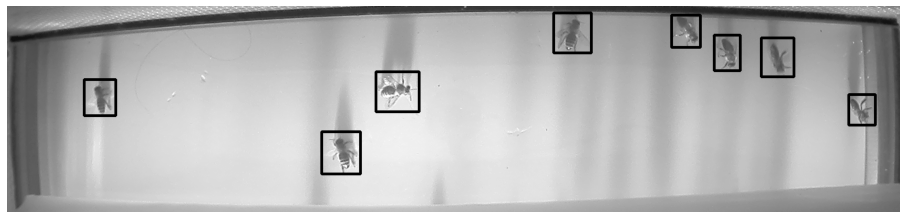

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

img_copy = sample.copy()
for box in boxes:
    cv2.rectangle(img_copy,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (0,255,0), 3)

ax.set_axis_off()
ax.imshow(img_copy, cmap='gray')
#ax.imshow(img_copy)

# Train

## Model: set optimizer

In [15]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]

if(ADAM_OPTI):
    optimizer = torch.optim.Adam(params,lr=LEARNING_RATE,weight_decay=WEIGHT_DECAY)
else:
    optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

## Start training

In [ ]:
loss_hist = Averager()
itr = 1

epoch_loss = []

for epoch in range(NUM_EPOCHS):
    loss_hist.reset()

    for images, targets in train_data_loader:

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad() # Sets the gradients of all optimized torch.Tensor s to zero.
        losses.backward() # gradients are computed
        optimizer.step() # updates the parameters

        #if itr % 50 == 0:
            #print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1

    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
    
    epoch_loss.append(loss_hist.value)
    print(f"Epoch #{epoch} loss: {loss_hist.value}")


	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /codebuild/output/src811146734/src/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)



Epoch #0 loss: 0.49996477346246443
Epoch #1 loss: 0.3828949036387106
Epoch #2 loss: 0.3555374519986411
Epoch #3 loss: 0.34234487407219905
Epoch #4 loss: 0.3309862340038332
Epoch #5 loss: 0.3238056190504382
Epoch #6 loss: 0.32097414491760234
Epoch #7 loss: 0.31471434334727627
Epoch #8 loss: 0.3122660764005656
Epoch #9 loss: 0.30940453870718676
Epoch #10 loss: 0.30252702463852865
Epoch #11 loss: 0.30037628748081624
Epoch #12 loss: 0.2959352644731601
Epoch #13 loss: 0.295342762193953
Epoch #14 loss: 0.28971085556751736
Epoch #15 loss: 0.2870233877847592
Epoch #16 loss: 0.2845414683924367
Epoch #17 loss: 0.27809349890456847
Epoch #18 loss: 0.27523022713015477
Epoch #19 loss: 0.27310394768199575
Epoch #20 loss: 0.2709686882821843


## Plot Loss

In [34]:
def plotLoss(data,saveName):
    if isinstance(data,(np.ndarray)):
        data = data.tolist()
        
    minValue = min(data)
    xmin = data.index(minValue)
    
    plt.plot(data)
    plt.plot(xmin,minValue,'or')
    
    plt.ylim(-0.1,1.3)
    plt.xticks(np.arange(0,NUM_EPOCHS, step=2))
    
    text = "epoch={}\nloss={:.3f}".format(xmin, minValue)
    props = dict(boxstyle='round', facecolor='#FFCC00', alpha=0.9)
    plt.text(len(data)*0.8, 1.1, text, bbox=props)
    #plt.annotate(text,(len(data)*0.8, 1.1))
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.title('Loss')
    plt.grid(True)
    plt.savefig(f'Plots/{saveName}.png')
    plt.show()
    plt.close()

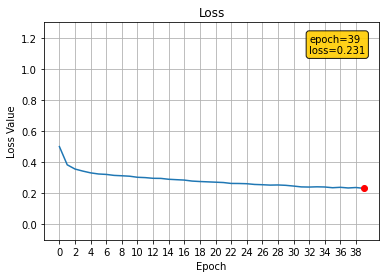

In [35]:
plotLoss(epoch_loss,f"version{VERSION}")

# Save/Load trained model

## Save

In [ ]:
torch.save(model, f"./TrainedNets/version{VERSION}.pth")

## Load

In [33]:
model = torch.load("./TrainedNets/version_15.pth")

# Evaluation

## Helpler functions

In [22]:
def generate_ious(gt_boxes, out_boxes):
    ious = np.zeros((len(gt_boxes), len(out_boxes)), dtype=np.float32)

    # for every ground-truth box:
    for gt_index, gt_box in enumerate(gt_boxes):
        xgt1, ygt1, xgt2, ygt2 = gt_box
        gt_area = (ygt2 - ygt1) * (xgt2 - xgt1)

        # calculate IOU for every predicted box
        for out_index, out_box in enumerate(out_boxes):
            xout1, yout1, xout2, yout2 = out_box
            out_area = (yout2 - yout1) * (xout2 - xout1)

            inter_x1 = max([xout1, xgt1])
            inter_y1 = max([yout1, ygt1])
            inter_x2 = min([xout2, xgt2])
            inter_y2 = min([yout2, ygt2])

            if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
                inter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
                iou = inter_area / (gt_area + out_area - inter_area)
            else:
                iou = 0.
            
            ious[gt_index, out_index] = iou
    return ious

In [23]:
def check_labels(ious):

    ious_thresh = np.where(ious<IOUS_THESHHOLD, 0, ious)

    def set_label(gt_i, out_i):
        ious_thresh[:,out_i] = 0
        ious_thresh[gt_i] = zerorow
        labels.append((gt_i, out_i, ious[gt_i][out_i]))           

    labels = []
    zerorow = np.zeros(len(ious[0]), dtype=np.bool)
    changed = True
    # Until no further mapping is founded
    while changed:
        changed = False
        # all bees, that have an unambiguous mapping
        for gt_index, ious_list in enumerate(ious_thresh):
            nonzero = np.nonzero(ious_list)[0]  # returns list with all indices with values != 0
            if len(nonzero) == 1:   # If only one value: one possible mapping 
                set_label(gt_index, nonzero[0])
                changed = True


        # if no unambiguous boces left: map maximum IOU
        if changed == False:
            (gt_index, out_index) = np.unravel_index(ious_thresh.argmax(), ious_thresh.shape) #returns incides of maximum value
            if ious_thresh[gt_index, out_index] != 0:
                set_label(gt_index, out_index)
                changed = True

    return labels  

In [24]:
def validate_pic(gt_boxes, out_boxes):
    ious_of_pic = generate_ious(gt_boxes, out_boxes)

    # calculate mapping of bounding boxes
    if len(out_boxes) > 0:
        labels = check_labels(ious_of_pic)
        TP = len(labels)
        TN = 0
        FN = len(gt_boxes) - TP
        FP = len(out_boxes) - TP

        accuracy = (TP + TN) / (TP + TN + FN + FP)
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
    else:
        accuracy = 0
        precision = 0
        recall = 0

    return(accuracy,precision,recall)

## Evaluation for one single image for testing evaluation algorithm

In [25]:
valid_iterator = iter(valid_data_loader)
model.eval()
cpu_device = torch.device("cpu")

In [26]:
images, targets = next(valid_iterator)
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [27]:
start = time.perf_counter()
outputs = model(images)
stop = time.perf_counter()

outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

out_boxes = outputs[0]['boxes']
gt_boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)

(accuracy, precision,recall) = validate_pic(gt_boxes, out_boxes)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print("time used:", stop - start, "sec")

Accuracy: 0.6666666666666666
Precision: 0.7096774193548387
Recall: 0.9166666666666666
time used: 0.11331952599721262 sec


## Plot image in gray scale

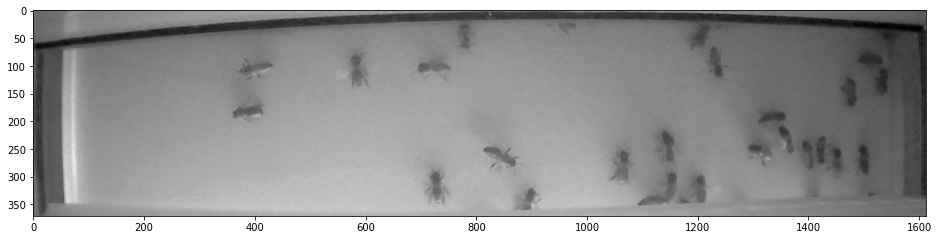

In [28]:
sample = images[0].permute(1,2,0).cpu().numpy()
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.imshow(sample, cmap='gray')

## Plot image with detected boxes (white) and ground-truth boxes (black)

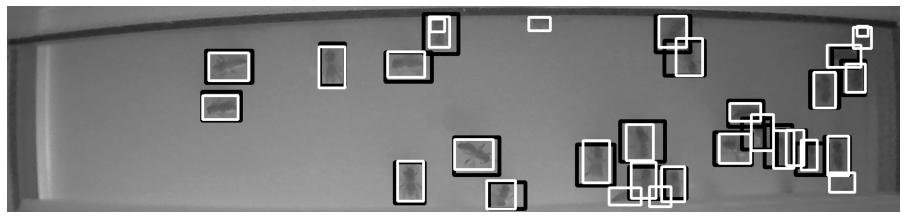

In [29]:
sample = images[0].permute(1,2,0).cpu().numpy()
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

img_copy = sample.copy()
i = 0
j = 0
breakpoint = 100

for box in gt_boxes:
    cv2.rectangle(img_copy,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (0), 5)
    j = j + 1 
    if j>=breakpoint:
        break
        
for box in out_boxes:
    cv2.rectangle(img_copy,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (1), 3)
    i = i + 1 
    if i>=breakpoint:
        break
    
    
ax.set_axis_off()

ax.imshow(img_copy, cmap='gray')

## Complete model evalaluation on whole test set

In [30]:
model.eval()
device = torch.device("cuda")
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.5], std=[0.5])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05

In [31]:
valid_iterator = iter(valid_data_loader)

accuracies=[]
precisions=[]
recalls=[]

for (i,(images, targets)) in enumerate(valid_iterator):
    #images, targets = next(valid_iterator)
    
    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    outputs = model(images)
    outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]

    out_boxes = outputs[0]['boxes']
    gt_boxes = targets[0]['boxes']

    (accuracy, precision, recall) = validate_pic(gt_boxes, out_boxes)
    
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    
    del images
    del targets
    del outputs
    
print("accuracies:", np.mean(accuracies))
print("precision:", np.mean(precisions))
print("recall:", np.mean(recalls))

accuracies: 0.5787149854890169
precision: 0.6182029019920611
recall: 0.8484818865537401


# Playground: generate and print anchor boxes

## Create data

In [ ]:
data = BeeDataset(5)

dummy_img = torch.zeros((1, 3, 371, 1613)).float()
print(dummy_img.shape)
dummy_img2 = torch.zeros((1, 3, 800, 800)).float()
print(dummy_img2.shape)

image = data[4][0].reshape((1, 3, 371, 1613))
bbox = data[4][1]["boxes"]
labels = data[4][1]["labels"]
sub_sampling_ratio = 16

### Reshape Feature Extraction Net to fit

In [6]:
model = torchvision.models.vgg16(pretrained=True)
fe = list(model.features)

req_features = []
k = dummy_img.clone()
#k = dummy_img2.clone()

for layer in fe:
    k = layer(k)
    if k.size()[2] < dummy_img.shape[2]//sub_sampling_ratio:
        break
    req_features.append(layer)
    out_channels = k.size()[1]

print(len(req_features))
print(out_channels)

faster_rcnn_fe_extractor = nn.Sequential(*req_features)
out_map = faster_rcnn_fe_extractor(image)
print(out_map.size())

[2021-01-29 17:46:36.194 pytorch-1-6-cpu-py36--ml-t3-medium-865bbbe9339dfff530ecf4d9e909:35 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-01-29 17:46:36.424 pytorch-1-6-cpu-py36--ml-t3-medium-865bbbe9339dfff530ecf4d9e909:35 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
30
512
torch.Size([1, 512, 23, 100])


### Create Anchor boxes

In [24]:
ratio = [0.5, 1, 2]
#changed anchor_scales from [8, 16, 32] to [4, 8, 16], because anchorboxes where too big
anchor_scales = [8, 16, 32]

print(dummy_img.shape)
print(image.shape)
fe_size_x = dummy_img.shape[3]//sub_sampling_ratio
fe_size_y = dummy_img.shape[2]//sub_sampling_ratio

anchors = np.zeros(((fe_size_x * fe_size_y * 9), 4), dtype=np.float32)

ctr_x = np.arange(sub_sampling_ratio, (fe_size_x+1) * sub_sampling_ratio, sub_sampling_ratio)
ctr_y = np.arange(sub_sampling_ratio, (fe_size_y+1) * sub_sampling_ratio, sub_sampling_ratio)

index = 0
for x in ctr_x:
    for y in ctr_y:
        for i in range(len(ratio)):
            for j in range(len(anchor_scales)):
                h = sub_sampling_ratio * anchor_scales[j] * np.sqrt(ratio[i])
                w = sub_sampling_ratio * anchor_scales[j] * np.sqrt(1./ ratio[i])

                anchors[index, 0] = y - h / 2.
                anchors[index, 1] = x - w / 2.
                anchors[index, 2] = y + h / 2.
                anchors[index, 3] = x + w / 2.
                index += 1

torch.Size([1, 3, 371, 1613])
torch.Size([1, 3, 371, 1613])


## Plot anchor boxes

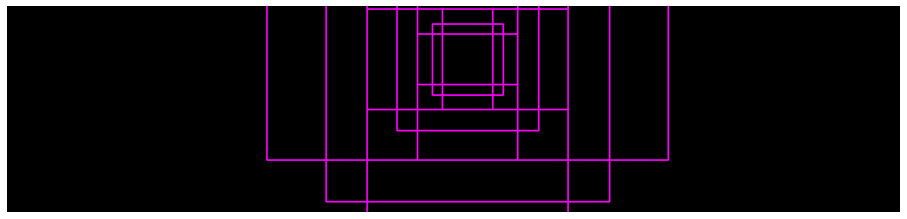

In [25]:
sample = torch.zeros((3, 371, 1613)).float().permute(1,2,0).cpu().numpy()
fig, ax = plt.subplots(1, 1, figsize=(16, 16))

img_copy = sample.copy()
for box in anchors[10601:10610]:
#for index in index_inside:
    #box = anchors[index]
    #Attention rectangle (pic, x, y, x2, y2)
    #box shape: (y, x, y2, x2)
    cv2.rectangle(img_copy,
                  (box[1], box[0]),
                  (box[3], box[2]),
                  (255, 0, 255), 2)

ax.set_axis_off()
ax.imshow(img_copy)